This notebook illustrates the way to run the simulations and perform some basic analyses with the output H5 files. The parameters used for these simulations are those reported in the paper `History dependent plasticity of glass: A mapping between atomistic and elasto-plastic models. Castellanos et al. Acta Materialia, Volume 241, December 2022, 118405`. See [here](https://www.sciencedirect.com/science/article/abs/pii/S1359645422007832?via%3Dihub). As detailed in the publication, the parameter values associated to transient state properties were obtained by optimizing these mesoscale simulation results against a set of reference molecular dynamics simulations in the transient regime, for different parent temperatures. The reader is referred to the publication for details. 

The stationary state parameters have the values optimized as described in `Insights from the quantitative calibration of an elasto-plastic model
from a Lennard-Jones atomic glass. Castellanos et al. Comptes Rendus. Physique, Volume 22 (2021) no. S3, pp. 135-162`. See [here](https://comptes-rendus.academie-sciences.fr/physique/item/10.5802/crphys.48.pdf).

In [1]:
import os
import subprocess
import time
import numpy as np
import pandas as pd
import time
import multiprocessing
import socket
import copy
from joblib import Parallel, delayed
from tqdm import tqdm
import matplotlib.pyplot as plt
import glob
import h5py

# Helpers

In [2]:
def write_cf_file(params,filename):
    """
    Write the input parameters as a text file.
    - params: dictionary with the parameters
    - filename: string with the output config file
    """

    with open(filename, 'w') as outfile:  
        outfile.write('# Listing of Parameters\n')
        outfile.write('# ---------------------\n')
        for section_name, section_params in params.items():
            outfile.write('subsection {}\n'.format(section_name))
            for param_name, param_value in section_params.items():
                if type(param_value)==bool: param_value = 'true' if param_value else 'false'
                outfile.write('  set {}'.format(param_name)+' '*(20-len(param_name))+' = {}\n'.format(param_value))    
            outfile.write('end\n\n\n')
    time.sleep(0.1)

    return


def replace_params(params, input_params):
    """
    Replace the default parameters with the desired ones.
    - params: dictionary with the default parameters
    - input_params: dictionary with the parameters to be replaced in the default ones
    """

    params = copy.deepcopy(params)
    
    for name, value in input_params.items():
        for section_name, section in params.items():
            if name in section.keys():
                section[name] = value

    return params


def run_job(job):
    """
    Run a job.
    - job: dictionary with the job definition, which includes simulation parameters, executable file and paths.
    """

    os.chdir(job['working_dir'])
    write_cf_file(job['params'], job['cfg_filename'])   

    # joblib uses loky backend, and the processes have names LokyProcess-2, LokyProcess-3 etc.
    # where the names corresponds to the number of parallel workers, so we can extract that number
    # to pin the simulations launched by a process to a specific CPU
    core_id = int(multiprocessing.current_process().name.split('-')[-1])-1

    proc = subprocess.Popen('taskset -c {} ./run_sim -f {}'.format(core_id, job['cfg_filename']), shell=True)
    proc.wait()    
                
    return job
      

def make_jobs(param_list, working_dir):
    """
    Create a list of jobs. Each job is created with an entry from the input
    list of simulation parameters.
    """
    
    output_dir_id = time.strftime('%Y_%m_%d_%H@')
    os.system('mkdir {} > /dev/null 2>&1'.format(working_dir+'/raw_data/'+output_dir_id))

    job_list = list()
    
    for n, params in enumerate(np.atleast_1d(param_list)):            
        
        cfg_filename = n

        params['Output']['output_path'] = './raw_data/{}'.format(output_dir_id)
            
        job = {'working_dir': working_dir,
               'cfg_filename': './raw_data/{}/{}.cfg'.format(output_dir_id,cfg_filename),
               'params': params,
               'target_func': run_job}
        
        job_list.append(job)
    
    return job_list


def create_output_structure(working_dir, exec_file):
    """
    Create a suitable directory structure for storing the simulation results. 
    """
    os.system('mkdir {} > /dev/null 2>&1'.format(working_dir))
    os.system('cp {} {} > /dev/null 2>&1'.format(exec_file, working_dir))
    os.system('mkdir {}/raw_data > /dev/null 2>&1'.format(working_dir))
    os.system('mkdir {}/pictures > /dev/null 2>&1'.format(working_dir))

# Run the simulations

Here we use the stationary state parameter values reported [here](https://comptes-rendus.academie-sciences.fr/physique/item/10.5802/crphys.48.pdf) for the length scale of `l=6.6` (however, as reported in [here](https://www.sciencedirect.com/science/article/abs/pii/S1359645422007832?via%3Dihub), in this case, the coupling constant is changed from `2.2` to `1.8` since the law relating the local plastic increments to the local shear stress was modified in the latter publication). For mesoscale elements with a length of `l=6.6`, the system is formed by `15x15` elements, and we measure local properties on patches with sides of `N_patch_list=1,2,4,8` elements. 

To run the simulations, we could do it in a simpler manner as described in the other notebook (`gallery/espci/python/run_and_process_stationary.ipynb`), in which case we must manually update the configuration file for the simulation corresponding to each parent temperature. Here we automatize the process. For that, we define the parameter values for each temperature and create jobs based on them. Once defined, the jobs are run in parallel using the joblib module.

In [3]:
# the optimal parameters for the transient regimes for each parent temperature
temperature_list = [0.32,0.34,0.37,0.4,0.5,0.7]

G_quench_dict = {
                0.32: 17.6,
                0.34: 15.6,
                0.37: 14.45,
                0.4: 13.0,
                0.5: 11.74,
                0.7: 10.86
                }

init_eigenstrain_std_dev_dict = {
                                0.32: 0.01155,
                                0.34: 0.012444,
                                0.37: 0.0126,
                                0.4: 0.0135,
                                0.5: 0.015795,
                                0.7: 0.014960
                                }

lambda_quench_dict = {
                    0.32: 2.469,
                    0.34: 1.97,
                    0.37: 1.53,
                    0.4: 1.3,
                    0.5: 1.14,
                    0.7: 0.94,
                    }

k_quench_dict = {
                 0.32: 3.415,
                0.34: 3.488,
                0.37: 4.09,
                0.4: 4.199,
                0.5: 4.39,
                0.7: 5.4
                }

gamma_pl_trans = 0.2
beta = -3.3

In [4]:
def submission_parent_T_static_quench(working_dir):

    # define some default parameters, that will be later replaced by other
    # values on a loop for each parent temperature. The default values of the
    # stationary state parameters are already set to the optimial ones  
    default_espci_params = {
                    'Material':{
                        'G': 13.2,
                        'G_quench': 13.2,
                        'alpha_tau': 0,
                        'K': 59,
                        'K_quench': 59,
                        'gamma_pl_trans': 0.5,
                        'beta': 0.,
                        'coupling_constant': 1.812,
                        'lambda': 2.0517,
                        'lambda_quench': 2.0517,
                        'k': 2.1818,
                        'k_quench': 2.1818,
                        'n_slip_systems': 9,
                        'init_eigenstrain': 'true',
                        'init_eigenstrain_std_dev': 0.0,
                        'init_eigenstrain_std_vol': 0.0,
                        'init_eigenstrain_av_vol': 0.0,
                        'init_eigenstrain_std_av_vol': 0.0,
                        'temperature_liquid': 0.25,
                        },

                    'Output':{
                        'filename': 'auto',
                        'output_path': './',
                        'snapshots_interval': 0.025,
                        'snapshots': 'patches,def_grad,stress',
                        'snapshots_max': 3.00,
                        'snapshots_min': 0.00,
                        'snapshots_sensitivity': 0.001,
                        'verbosity': False},

                    'Simulation Setup':{
                        'Nx': 15,
                        'Ny': 15,
                        'N_patch_list': '1,2,4,8',
                        'n_theta': 4,
                        'seed': 1234567,
                        'n_rep': 1,
                        'monitor_name': 'total_strain',
                        'monitor_limit': 0.25,
                        'parent_liquid': 'false',
                        'thermal_relaxation': 'false',
                        'reload': 'false',
                        'het_elasticity': 'false',
                        'do_ee': 'true'}
                    }


    param_combinations = list()

    for T in temperature_list:
        # define here the parameter values that will be replaced in the dictionary
        # of default parameter values above
        param_combinations += [ {'temperature_liquid': T,
                                'k_quench': k_quench_dict[T],
                                'lambda_quench': lambda_quench_dict[T],
                                'gamma_pl_trans': gamma_pl_trans,
                                'G_quench': G_quench_dict[T],
                                'beta': beta,
                                'init_eigenstrain_std_dev': init_eigenstrain_std_dev_dict[T],
                                } ]

    n_realizations = 32

    param_combinations_repeated = list()
    for p in param_combinations:
        for n in range(n_realizations): # repeat each param combination this number of times, each wich a different seed
            cfg_dict = replace_params(default_espci_params,p)
            cfg_dict['Simulation Setup']['seed'] = np.random.randint(0,1e7)
            param_combinations_repeated.append( cfg_dict )

    # parameters that will be used to create cofig filenames. We use see and temperature because are
    # the most meaninful ones in this specific case
    keys = ['seed','temperature_liquid']
    job_list = make_jobs(param_combinations_repeated, working_dir)

    return job_list

In [5]:
path = '<you-output-path>'
exec_file = '<path-to-MEPLS-exec-file>'

In [ ]:
output_dir = 'sim_liquid_parent_T'
working_dir = f'{path}/{output_dir}'

create_output_structure(working_dir, exec_file)
job_list = submission_parent_T_static_quench(working_dir)

n_jobs = multiprocessing.cpu_count()
Parallel(n_jobs=n_jobs)(delayed(run_job)(job) for job in tqdm(job_list))

# Plot the mascroscale response vs temperature

Here we create the plot of the macroscale response for different parent temperatures. For that, we use the dataset that contains a summary of the macroscale response, located at `/AQS/macro_evolution` within the output H5 files hierarchy. This dataset has less granularity than those based on discrete events (see`/AQS/driving_events`) but is more straightforward to deal with.

In [7]:
meso_filenames = glob.glob(f'{working_dir}/raw_data/*/*h5')

df_list = list()

for filename in tqdm(meso_filenames):  
    file = h5py.File(filename,'r') 
    df_ = np.array(file['AQS/macro_evolution'])
    df = pd.DataFrame(df_, columns=df_.dtype.names).loc[:,['total_strain','ext_stress']]
    df['T'] = file.attrs['temperature_liquid']
    df_list.append(df)
    file.close()

df = pd.concat(df_list)

100%|██████████| 192/192 [00:01<00:00, 176.14it/s]


In [8]:
df['strain_bin'] = pd.cut(df['total_strain'], np.arange(0,1,0.01))

agg = df.groupby(['strain_bin','T'], as_index=False).mean().dropna().sort_values(['total_strain'])

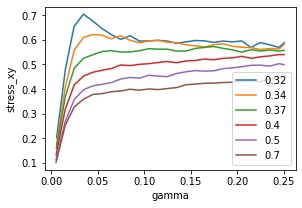

In [9]:
fig, ax = plt.subplots(1,1, sharex=True, figsize=(4.5,3))    

for T, g in agg.groupby('T'):
    ax.plot(g['total_strain'], g['ext_stress'], label=T)

plt.xlabel('gamma')
plt.ylabel('stress_xy')
plt.legend()    